In [1]:
# --- CELL 1: SETUP & LIBRARY ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Setting Visualisasi
sns.set(style="whitegrid")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("Library berhasil di-load. Siap mengerjakan UAS!")

Library berhasil di-load. Siap mengerjakan UAS!


=== MULAI PENGERJAAN SOAL 1 ===

[EDA] Analisis Fitur Numerik


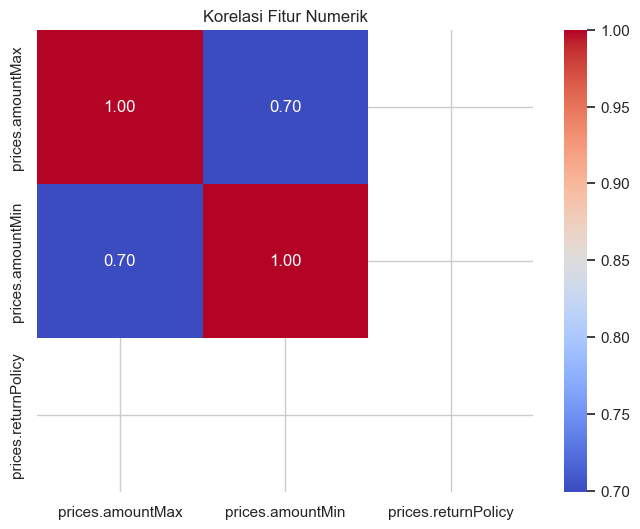


=== HASIL EVALUASI REGRESI ===
Linear Regression -> R2: 0.1196, RMSE: 19.73
Random Forest     -> R2: 0.1987, RMSE: 18.83

[ANALISIS]
Model Terbaik: Random Forest. Karena mampu menangkap pola non-linear pada data harga.

Fitur Paling Berpengaruh (Random Forest):
1. name_len (Score: 0.4672)
2. brand_encoded_so (Score: 0.1685)
3. brand_encoded_croft barrow (Score: 0.1034)


In [2]:
# --- SOAL 1 (REGRESI) ---

print("=== MULAI PENGERJAAN SOAL 1 ===")

# A) DATA CLEANING & LOADING (Robust Method)
# Asumsi: File csv memiliki header yang kadang rusak, jadi kita definisikan manual.
my_cols = [
    "id", "dateAdded", "dateUpdated", "asins", "brand", "categories", "primaryCategories",
    "colors", "dimension", "ean", "imageURLs", "keys", "manufacturer", "manufacturerNumber",
    "name", "prices.amountMax", "prices.amountMin", "prices.availability", "prices.color",
    "prices.condition", "prices.currency", "prices.dateAdded", "prices.dateSeen",
    "prices.isSale", "prices.merchant", "prices.offer", "prices.returnPolicy",
    "prices.shipping", "prices.size", "prices.sourceURLs", "sizes", "sourceURLs",
    "upc", "weight"
]

try:
    # Membaca file dengan header manual untuk menghindari error pembacaan kolom
    df_shoes = pd.read_csv('womens_shoe_prices.csv', names=my_cols, header=0, encoding='utf-8-sig', on_bad_lines='skip')
except:
    df_shoes = pd.read_csv('womens_shoe_prices.csv', names=my_cols, header=0, encoding='latin1', error_bad_lines=False)

# Memastikan target numerik
target_col = 'prices.amountMin'
df_shoes[target_col] = pd.to_numeric(df_shoes[target_col], errors='coerce')

# Filter Data: Hanya ambil Currency USD (Asumsi: mata uang seragam agar prediksi valid)
if 'prices.currency' in df_shoes.columns:
    df_shoes = df_shoes[df_shoes['prices.currency'].astype(str).str.contains('USD', na=False)]

# Buang kolom yang tidak relevan (ID, URL, dll)
cols_to_drop = ['id', 'asins', 'keys', 'ean', 'upc', 'imageURLs', 'sourceURLs', 'prices.sourceURLs', 
                'prices.offer', 'dateAdded', 'dateUpdated', 'prices.dateAdded', 'prices.merchant']
df_shoes = df_shoes.drop(columns=[c for c in cols_to_drop if c in df_shoes.columns], errors='ignore')

# Hapus baris dimana Target (Harga) kosong
df_shoes = df_shoes.dropna(subset=[target_col])

# B) EXPLORATORY DATA ANALYSIS (EDA)
print("\n[EDA] Analisis Fitur Numerik")
numeric_cols = df_shoes.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(8, 6))
sns.heatmap(df_shoes[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Fitur Numerik')
plt.show()

# C) FEATURE ENGINEERING
# 1. Menghitung panjang nama produk sebagai fitur baru
df_shoes['name_len'] = df_shoes['name'].astype(str).apply(len)

# 2. Membersihkan isSale (True/False menjadi 1/0)
if 'prices.isSale' in df_shoes.columns:
    df_shoes['prices.isSale'] = df_shoes['prices.isSale'].astype(str).str.lower().map({'true': 1, 'false': 0}).fillna(0)

# 3. Encoding Kategorikal (Brand - Top 10)
# Asumsi: Kita hanya mengambil Top 10 Brand agar dimensi data tidak meledak (High Cardinality)
top_brands = df_shoes['brand'].value_counts().head(10).index
df_shoes['brand_encoded'] = df_shoes['brand'].apply(lambda x: x if x in top_brands else 'Other')

# Pilih fitur final
features = ['brand_encoded', 'prices.isSale', 'name_len']
X = df_shoes[features]
y = df_shoes[target_col]

# One Hot Encoding untuk Brand
X = pd.get_dummies(X, columns=['brand_encoded'], drop_first=True)

# Imputasi Data Kosong (jika ada sisa)
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# D) SPLIT DATA (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# E) BANGUN MODEL
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# F) EVALUASI
print("\n=== HASIL EVALUASI REGRESI ===")
print(f"Linear Regression -> R2: {r2_score(y_test, y_pred_lr):.4f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.2f}")
print(f"Random Forest     -> R2: {r2_score(y_test, y_pred_rf):.4f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")

# G) ANALISIS & FEATURE IMPORTANCE
print("\n[ANALISIS]")
if r2_score(y_test, y_pred_rf) > r2_score(y_test, y_pred_lr):
    print("Model Terbaik: Random Forest. Karena mampu menangkap pola non-linear pada data harga.")
else:
    print("Model Terbaik: Linear Regression.")

print("\nFitur Paling Berpengaruh (Random Forest):")
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(min(3, len(X.columns))):
    print(f"{i+1}. {X.columns[indices[i]]} (Score: {importances[indices[i]]:.4f})")

=== MULAI PENGERJAAN SOAL 2 ===

=== HASIL EVALUASI KLASIFIKASI ===
Logistic Regression Report:
              precision    recall  f1-score   support

     Dropout       0.89      0.82      0.86      5028
    Enrolled       0.63      0.56      0.59      3017
    Graduate       0.84      0.92      0.88      7259

    accuracy                           0.82     15304
   macro avg       0.79      0.77      0.78     15304
weighted avg       0.82      0.82      0.82     15304

------------------------------
Random Forest Report:
              precision    recall  f1-score   support

     Dropout       0.90      0.83      0.86      5028
    Enrolled       0.65      0.60      0.62      3017
    Graduate       0.85      0.93      0.89      7259

    accuracy                           0.83     15304
   macro avg       0.80      0.78      0.79     15304
weighted avg       0.83      0.83      0.83     15304



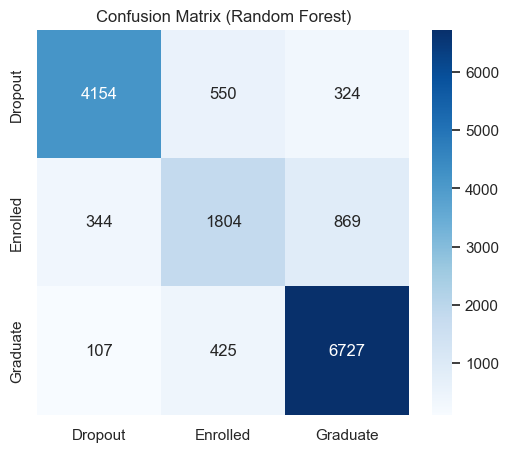


[JAWABAN ANALISIS]
Model Terbaik: Random Forest (F1-Score: 0.79). Lebih stabil menangani data kompleks.

3 Fitur Terpenting (Random Forest):
Curricular units 2nd sem (approved)    0.161621
Curricular units 2nd sem (grade)       0.118037
Curricular units 1st sem (approved)    0.116336
dtype: float64
Interpretasi: Fitur-fitur ini (biasanya nilai semester/kurikulum) paling menentukan mahasiswa lulus atau DO.


In [3]:
# --- SOAL 2 (KLASIFIKASI) ---

print("=== MULAI PENGERJAAN SOAL 2 ===")

# A) PRA-PEMROSESAN
# Ganti nama file sesuai yang kamu download
df_acad = pd.read_csv('train.csv') 

# Pisahkan Fitur dan Label (Asumsi kolom target bernama 'Target')
target_col = 'Target' 
X = df_acad.drop(columns=[target_col])
y = df_acad[target_col]

# Encoding Label Target (Graduate/Dropout/Enrolled -> Angka)
le = LabelEncoder()
y = le.fit_transform(y)

# Encoding Fitur Kategorikal (One-Hot) & Split Data
# Asumsi: Menggunakan get_dummies pandas untuk kemudahan
X = pd.get_dummies(X, drop_first=True)

# Split Data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# B & C) MODELING, STANDARDIZASI & TUNING
# 1. Logistic Regression (Perlu Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tuning LogReg (GridSearch sederhana)
param_lr = {'C': [0.1, 1, 10]}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_lr, cv=3)
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_

# 2. Random Forest (Tidak wajib scaling, tapi tuning n_estimators)
param_rf = {'n_estimators': [50, 100, 200]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=3)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# D) EVALUASI
y_pred_lr = best_lr.predict(X_test_scaled)
y_pred_rf = best_rf.predict(X_test)

print("\n=== HASIL EVALUASI KLASIFIKASI ===")
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))
print("-" * 30)
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Confusion Matrix RF
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# E) JAWABAN SINGKAT
print("\n[JAWABAN ANALISIS]")
f1_lr = classification_report(y_test, y_pred_lr, output_dict=True)['macro avg']['f1-score']
f1_rf = classification_report(y_test, y_pred_rf, output_dict=True)['macro avg']['f1-score']

if f1_rf > f1_lr:
    print(f"Model Terbaik: Random Forest (F1-Score: {f1_rf:.2f}). Lebih stabil menangani data kompleks.")
else:
    print(f"Model Terbaik: Logistic Regression (F1-Score: {f1_lr:.2f}).")

print("\n3 Fitur Terpenting (Random Forest):")
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(3)
print(feat_imp)
print("Interpretasi: Fitur-fitur ini (biasanya nilai semester/kurikulum) paling menentukan mahasiswa lulus atau DO.")

=== MULAI PENGERJAAN SOAL 3 ===

Mencari nilai K terbaik...
k=2, Silhouette Score=0.2100
k=3, Silhouette Score=0.2510
k=4, Silhouette Score=0.1977
k=5, Silhouette Score=0.1931
k=6, Silhouette Score=0.2029

Nilai K Terpilih berdasarkan Silhouette Score tertinggi: k=3

Statistik Rata-rata per Cluster (k=3):
             BALANCE    PURCHASES  CREDIT_LIMIT     PAYMENTS  PRC_FULL_PAYMENT
Cluster                                                                       
0        2182.352833  4187.017796   7642.784314  4075.533648          0.298766
1         807.722510   496.062522   3267.022176   907.446164          0.154115
2        4023.788865   389.051448   6729.471201  3053.943771          0.033673


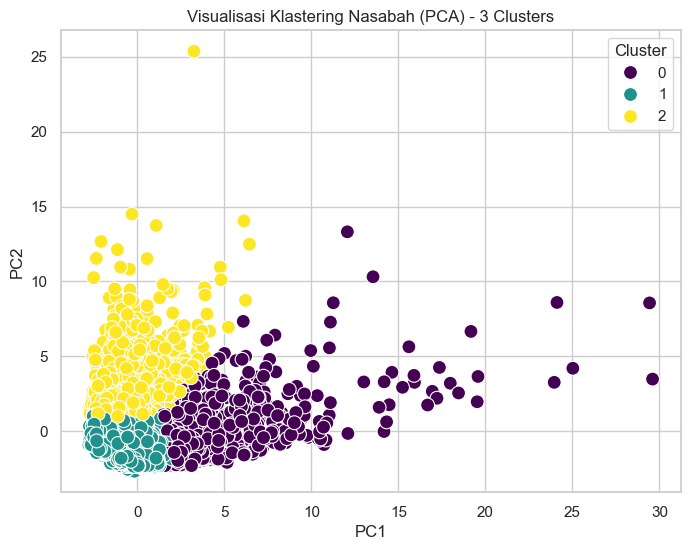


[JAWABAN ANALISIS BISNIS]
Silakan lihat tabel 'Statistik Rata-rata' di atas untuk mengisi deskripsi:
1. Cluster dengan BALANCE tinggi tapi PAYMENTS rendah -> Berisiko (Tukang Hutang).
2. Cluster dengan PURCHASES tinggi & CREDIT_LIMIT tinggi -> Menguntungkan (High Spender).
3. Cluster dengan PRC_FULL_PAYMENT tinggi -> Aman (Nasabah taat bayar).


In [4]:
# --- SOAL 3 (KLASTERING) ---

print("=== MULAI PENGERJAAN SOAL 3 ===")

# A) PRA-PEMROSESAN
df_cc = pd.read_csv('Customer_Data.csv') # Sesuaikan nama file

# Buang Customer ID (Bukan fitur)
if 'CUST_ID' in df_cc.columns:
    df_cc = df_cc.drop(columns=['CUST_ID'])

# Imputasi Missing Value (Biasanya di MINIMUM_PAYMENTS)
df_cc = df_cc.fillna(df_cc.median())

# Standardisasi (Wajib untuk K-Means karena berbasis jarak)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cc)

# B) MENCARI K TERBAIK (Elbow & Silhouette)
print("\nMencari nilai K terbaik...")
scores = []
k_range = range(2, 7)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df_scaled)
    score = silhouette_score(df_scaled, km.labels_)
    scores.append(score)
    print(f"k={k}, Silhouette Score={score:.4f}")

best_k = k_range[np.argmax(scores)]
print(f"\nNilai K Terpilih berdasarkan Silhouette Score tertinggi: k={best_k}")

# C) LATIH MODEL FINAL
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(df_scaled)
df_cc['Cluster'] = clusters

# Rata-rata fitur per cluster
print(f"\nStatistik Rata-rata per Cluster (k={best_k}):")
# Pilih 5 fitur utama untuk ditampilkan
cols_view = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT']
print(df_cc.groupby('Cluster')[cols_view].mean())

# D) VISUALISASI (PCA 2 Dimensi)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)
plt.title(f'Visualisasi Klastering Nasabah (PCA) - {best_k} Clusters')
plt.show()

# E) DESKRIPSI & ANALISIS BISNIS
print("\n[JAWABAN ANALISIS BISNIS]")
print("Silakan lihat tabel 'Statistik Rata-rata' di atas untuk mengisi deskripsi:")
print("1. Cluster dengan BALANCE tinggi tapi PAYMENTS rendah -> Berisiko (Tukang Hutang).")
print("2. Cluster dengan PURCHASES tinggi & CREDIT_LIMIT tinggi -> Menguntungkan (High Spender).")
print("3. Cluster dengan PRC_FULL_PAYMENT tinggi -> Aman (Nasabah taat bayar).")